In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
import math
import scipy.integrate as integrate

In [ ]:
def coeff_eval(x: sm.core.symbol.Symbol, f : sm.Function, Cheby_poly : sm.Function, k: int):
    """
    Calcuates the Coefficients to the
    Chebyshev expansion. 
    """
    inte = 0
    if k == 0:
        inte = (1./sm.pi) * f / (sm.sqrt(1 - x**2))
    else :
        inte = (2. / sm.pi) * f * Cheby_poly / (sm.sqrt(1 - x**2))
    
    return integrate.quad(sm.lambdify(x, inte, modules = ['numpy']), -1, 1)[0]
   
    
def Cheb (x : sm.core.symbol.Symbol, n_eval: int):
    """
    Returns the n-th Chebyshev polynomial.
    """
    j = sm.symbols('j', integer = True)
    n = sm.Symbol('n', integer = True)
    series = sm.Sum(sm.binomial(n, 2*j)* (x**2 - 1)**j * x**(n - 2*j), (j, 0, sm.floor(n/2)))
    return series.subs({n: n_eval}).doit()

def Cheb_expansion(f : sm.Function, k : int, cheb_dict: dict):
    x = sm.Symbol('x')    
    cheb_coeff = np.zeros(k+1)
    cheb_funcs = []
    for i in range(k+1):
        cheb = Cheb(x, i)
        if i not in cheb_dict.keys():
            cheb_coeff[i] = coeff_eval(x, f, cheb, i)    
            cheb_dict[i] = cheb_coeff[i]
        else :
            cheb_coeff[i] = cheb_dict[i]
            
        cheb_funcs.append(cheb) 

    return cheb_coeff, cheb_funcs

def sup_norm(f_true : np.ndarray, f_approx : np.ndarray):
    f_diff = np.abs(f_true - f_approx)
    return np.max(f_diff)


In [ ]:
### COMPUTING THE COEFFICIENTS
cheb_dict = {}
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
xs = np.linspace(-1, 1, 100)
x = sm.Symbol('x')
f = sm.exp(x)
ks = range(1, 21, 1)
sup_norms = np.zeros(len(ks))
approxs = np.zeros((len(ks), 100))

lam_true = sm.lambdify(x, f, modules=['numpy'])
lam_x = sm.lambdify(x, f, modules=['numpy'])

for i, k in enumerate(ks):
    cheb_coeff, cheb_func = Cheb_expansion(f, k, cheb_dict)
    sum = 0
    lam_approx = 0
    for j in range(len(cheb_coeff)):
        sum += cheb_coeff[j] * cheb_func[j]
    lam_approx = sm.lambdify(x, sum, modules=['numpy'])
    approxs[i, :] = lam_approx(xs)
    sup_norms[i] = sup_norm(lam_true(xs), approxs[i, :])

    print(f'{(i+1)/len(ks) * 100.}%')

for i in range(len(approxs)):
    if i in [2, 5, 10, 15, 20]:
       axs[0].plot(xs, approxs[i-1, :], label = f'{ks[i-1]}')

axs[0].plot(xs, lam_x(xs), label = "True")

# Plotting Aesthetics
axs[0].set_title(f'Chebyshev Expansion Up to Degree {ks[-1]}')
axs[0].legend()
axs[0].grid(True)
axs[0].set_facecolor((0.9, 0.9, 0.9)) 
axs[0].set_xlabel("x")
axs[0].set_ylim([0, max(lam_x(xs))])

axs[1].scatter(ks, sup_norms)
axs[1].set_xticks(ks)
axs[1].grid(True)
axs[1].set_facecolor((0.9, 0.9, 0.9))
axs[1].set_title("Error for Chebyshev Approximation") 
axs[1].set_xlabel("Chebyshev Polynomial Degree")
axs[1].set_ylabel("Error (Sup Norm)")
axs[1].set_yscale('log')
plt.show()


In [ ]:
# CALCULATING THE MATRIX
# Equispaced points


f = sm.exp(x)
x = sm.Symbol('x')
ns = np.array(range(1, 21, 1))
x_interp = np.linspace(-1, 1, 100)
lm_true = sm.lambdify(x, f, modules=['numpy'])
func_evals = lm_true(x_interp)
approxs = np.zeros((len(ns), 100))
errors = np.zeros(len(ns))
for m, n in enumerate(ns+1):
    xs = np.linspace(-1, 1, n)
    V = np.zeros((n, n))

    # Calculating the function evals
    f_evals = lm_true(xs)

    for j in range(n):
        # Forming the matrix
        cheb_func = Cheb(x, j)
        lm_cheb = sm.lambdify(x, cheb_func, modules = ['numpy'])
        if type(lm_cheb(xs))== int or type(lm_cheb(xs))== float:
            for i in range(n):
                V[i, j] = lm_cheb(xs)
        else:
            for i, pt_eval in enumerate(lm_cheb(xs)):
                V[i, j] = pt_eval

    coeffs = np.linalg.solve(V, f_evals)
    sum = 0
    for k in range(len(coeffs)):
        sum += coeffs[k]*Cheb(x, k)
    lm_cheb = sm.lambdify(x, sum, modules = ['numpy'])


    # Saving
    approxs[m, :] = lm_cheb(x_interp)
    errors[m] = sup_norm(func_evals, approxs[m,:])
fig, axs = plt.subplots(1, 2, figsize = (16, 6))


for i in range(len(approxs)):
    if i+1 in [2, 5, 10, 15, 20]:
       axs[0].plot(x_interp, approxs[i, :], label = f'{ns[i]}')

axs[0].plot(x_interp, func_evals, label = "True")

# Plotting Aesthetics
axs[0].set_title(f'Chebyshev Expansion Up to Degree {ns[-1]}')
axs[0].legend()
axs[0].grid(True)
axs[0].set_facecolor((0.9, 0.9, 0.9)) 
axs[0].set_xlabel("x")
axs[0].set_ylim([0, max(lam_x(xs))])

axs[1].scatter(ns, errors)
axs[1].set_xticks(ks)
axs[1].grid(True)
axs[1].set_facecolor((0.9, 0.9, 0.9))
axs[1].set_title("Error for Chebyshev Approximation") 
axs[1].set_xlabel("Chebyshev Polynomial Degree")
axs[1].set_ylabel("Error (Sup Norm)")
axs[1].set_yscale('log')
plt.show()

In [3]:
def bound(rho, n):
    return 2*np.exp(rho)/((rho - 1) * rho**n)

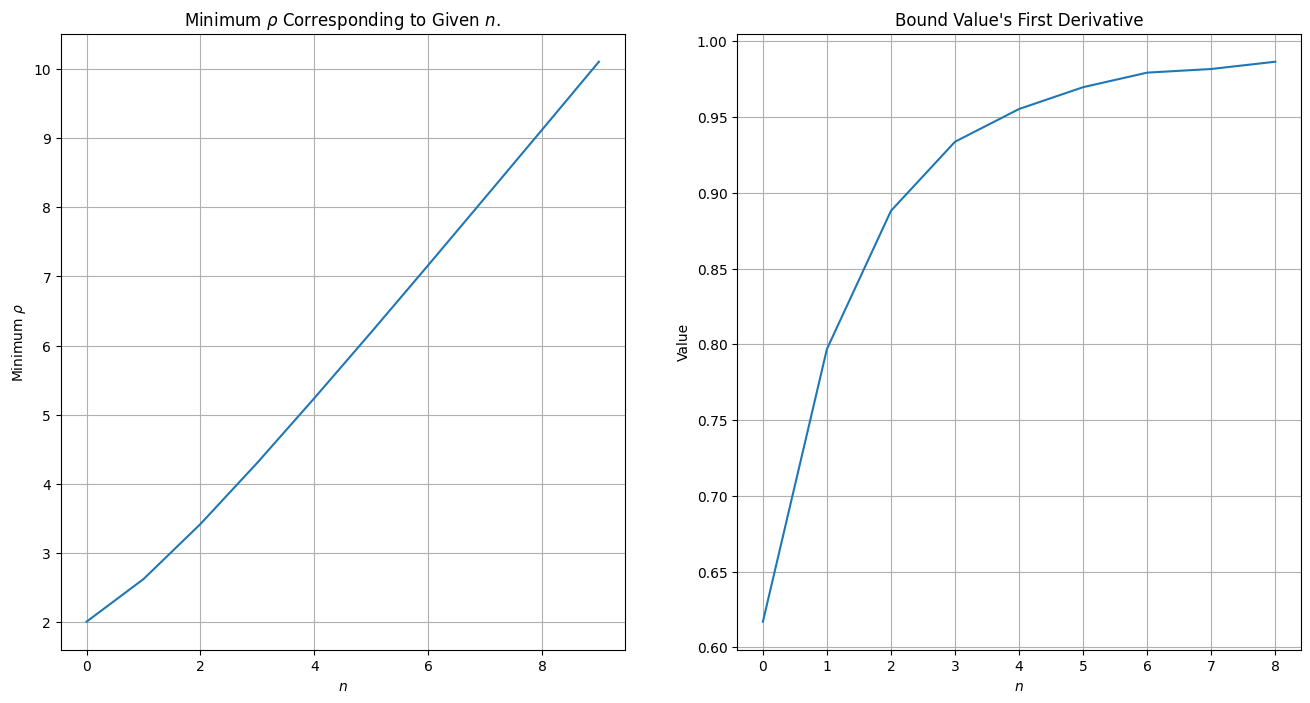

In [71]:
size = int(10)
maxsize = int(25)
xs = np.linspace(1+1e-4, maxsize, 10000)
mins_rho = np.zeros(size)
mins_val = np.zeros(size)
for n in range(size):
    mins_rho[n] = xs[np.argmin(bound(xs, n))]
    mins_val[n] = np.min(bound(xs, n))

rho_min = np.diff(mins_rho)/np.diff((range(1, n+2)))
fig, axs = plt.subplots(1, 2, figsize = (16, 8))
axs[0].plot(range(size), mins_rho)

axs[1].plot(range(size-1), rho_min)
#axs.set_yscale('log')
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_ylabel(r"Minimum $\rho$")
axs[0].set_title(r"Minimum $\rho$ Corresponding to Given $n$.")
axs[0].set_xlabel("$n$")
axs[1].set_title("Bound Value's First Derivative")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("$n$")

plt.show()
